<a href="https://colab.research.google.com/github/TeRRyB44/Determination-of-SoC-and-SoH-of-LiFePO4-Battery-in-Battery-Management-System-using-Machine-Learning/blob/main/SOC_AND_SOH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔹 Polynomial Regression:
R² Score: 0.9887
MSE: 0.0007

🔹 Model Coefficients:
Voltage: 0.3848
Current: -0.3341
Temperature: -0.5391
Voltage^2: 0.6682
Voltage Current: 0.3305
Voltage Temperature: 0.1143
Current^2: 0.1519
Current Temperature: -0.0540
Temperature^2: 0.5768
Intercept: 0.0705

Model and scaler saved successfully!


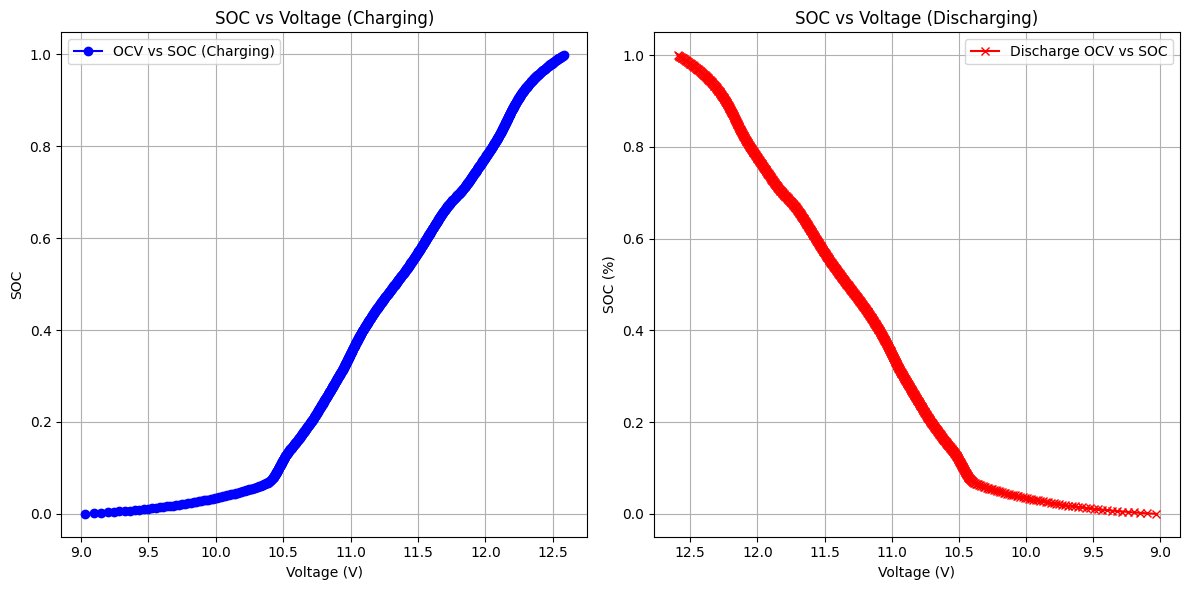

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import joblib

# Load the datasets
ocv_data = pd.read_csv("OCV_vs_SOC_curve.csv")
exp_data = pd.read_csv("Experimental_data_aged_cell.csv")
discharge_data = pd.read_csv("Discharge_OCV_vs_SOC.csv")

# Handle missing values
ocv_data.fillna(ocv_data.mean(), inplace=True)
exp_data.fillna(exp_data.mean(), inplace=True)
discharge_data.fillna(discharge_data.mean(), inplace=True)

# Interpolate SOC for experimental data
voltage_values = ocv_data["V1"].values
voltage_values1 = ocv_data["V0"].values
soc_values = ocv_data["SOC"].values
exp_data["SOC"] = np.interp(exp_data["Voltage"], voltage_values, soc_values)

# Features and target
X_exp = exp_data[['Voltage', 'Current', 'Temperature']].values
Y_exp = exp_data['SOC'].values

# Use MinMaxScaler for better scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_exp)

# Polynomial Features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Train Polynomial Regression
poly_model = LinearRegression()
poly_model.fit(X_poly, Y_exp)

# Evaluate Polynomial Model
Y_poly_pred = poly_model.predict(X_poly)
print("🔹 Polynomial Regression:")
print(f"R² Score: {r2_score(Y_exp, Y_poly_pred):.4f}")
print(f"MSE: {mean_squared_error(Y_exp, Y_poly_pred):.4f}")

# Extract Polynomial Features and Coefficients
feature_names = poly.get_feature_names_out(['Voltage', 'Current', 'Temperature'])
coefficients = poly_model.coef_
intercept = poly_model.intercept_

print("\n🔹 Model Coefficients:")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")

print(f"Intercept: {intercept:.4f}")

# If Polynomial Regression fails, try Random Forest
if all(coef == 0 for coef in coefficients):
    print("\n🔹 Polynomial Regression failed. Trying Random Forest...")

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_scaled, Y_exp)
    Y_rf_pred = rf_model.predict(X_scaled)

    print(f"R² Score (Random Forest): {r2_score(Y_exp, Y_rf_pred):.4f}")
    print(f"MSE (Random Forest): {mean_squared_error(Y_exp, Y_rf_pred):.4f}")

    best_model = rf_model
else:
    best_model = poly_model

# Save the model and scaler
joblib.dump(best_model, "soc_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("\nModel and scaler saved successfully!")

# Plot SOC vs Voltage for charging (OCV vs SOC)
plt.figure(figsize=(12, 6))

# Charging Plot (OCV vs SOC)
plt.subplot(1, 2, 1)
plt.plot(voltage_values1, soc_values, color='blue', marker='o', label='OCV vs SOC (Charging)')
plt.xlabel("Voltage (V)")
plt.ylabel("SOC")
plt.title("SOC vs Voltage (Charging)")
plt.grid(True)
plt.legend()

# Discharging Plot (Discharge OCV vs SOC)
discharge_voltage = discharge_data["V0"].values
discharge_soc = discharge_data["SOC"].values
plt.subplot(1, 2, 2)
plt.plot(discharge_voltage, discharge_soc, color='red', marker='x', label='Discharge OCV vs SOC')
plt.gca().invert_xaxis()  # Invert x-axis for declining trend
plt.xlabel("Voltage (V)")
plt.ylabel("SOC (%)")
plt.title("SOC vs Voltage (Discharging)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
